In [1]:
import os
os.chdir('/home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis')
print("Working Directory:", os.getcwd())

import re
import json

import pandas as pd
import ipywidgets as widgets
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
from nonverbal_communication_analysis.environment import (DATASET_SYNC,
                                                          OPENPOSE_OUTPUT_DIR, OPENFACE_OUTPUT_DIR,
                                                          DENSEPOSE_OUTPUT_DIR,
                                                          VALID_OUTPUT_FILE_TYPES)

Working Directory: /home/fraza0/Desktop/MEI/TESE/nonverbal_communication_analysis


In [2]:
GROUPS = ['3CLC9VWR', '4ZAI4OPO', '0436INH4']
GROUPS = GROUPS[:1]

In [3]:
df_structure = pd.DataFrame(columns=['group', 'task', 'camera', 'frame', 'n_subjects', 'n_valids'])
df_structure

,group,task,camera,frame,n_subjects,n_valids


# Face

In [4]:
def is_valid_face(keypoints: dict):
    invalid_entries = 0
    
    if np.sum(list(keypoints.values())) == 0:
        return 0
    return 1

## OpenPose

In [5]:
%%time
openpose_face = df_structure.copy()

for GROUP_ID in GROUPS:
    if not Path(GROUP_ID+'_face_openpose_df.csv').is_file():
        group_path = OPENPOSE_OUTPUT_DIR / GROUP_ID / (GROUP_ID + '_clean')
        tasks_paths = [x for x in group_path.iterdir() if 'task' in x.name]
        for task_path in tasks_paths:
            cameras_paths = [x for x in task_path.iterdir() if 'pc' in x.name]
            for camera_path in cameras_paths:
                input_files = [x for x in camera_path.iterdir() if x.suffix in VALID_OUTPUT_FILE_TYPES]
                total_files = len(input_files)
                for file in input_files[:]:
                    frame = int(re.search(r'(?<=_)(\d{12})(?=_)',
                                              file.name).group(0))
                    data = json.load(open(file))
                    df = pd.json_normalize(data['subjects'], max_level=0)
                    n_subjects = len(df)
                    valid_subjects = 0
                    for _, subject in df.iterrows():
                        valid_subjects += is_valid_face(subject['face']['openpose'])
                    openpose_face = openpose_face.append({'group': GROUP_ID,
                                                          'task': task_path.name,
                                                          'camera': camera_path.name,
                                                          'frame': frame,
                                                          'n_subjects': n_subjects,
                                                          'n_valids': valid_subjects},
                                                          ignore_index=True)
        openpose_face.to_csv(GROUP_ID+'_face_openpose_df.csv')
    else:
        print("File exists")
        tmp_openpose_face = pd.read_csv(GROUP_ID+'_face_openpose_df.csv', usecols=list(openpose_face.columns))
        openpose_face = openpose_face.append(tmp_openpose_face)

File exists
CPU times: user 145 ms, sys: 30.1 ms, total: 175 ms
Wall time: 432 ms


In [6]:
openpose_face.head()

,group,task,camera,frame,n_subjects,n_valids
0,3CLC9VWR,task_1,pc2,23971,4,1
1,3CLC9VWR,task_1,pc2,14332,4,0
2,3CLC9VWR,task_1,pc2,24398,4,1
3,3CLC9VWR,task_1,pc2,4919,4,1
4,3CLC9VWR,task_1,pc2,7184,4,1


## OpenFace

In [7]:
%%time
openface_face = df_structure.copy()

for GROUP_ID in GROUPS:
    if not Path(GROUP_ID+'_face_openface_df.csv').is_file():
        group_path = OPENFACE_OUTPUT_DIR / GROUP_ID / (GROUP_ID + '_clean')
        tasks_paths = [x for x in group_path.iterdir() if 'task' in x.name]
        for task_path in tasks_paths:
            cameras_paths = [x for x in task_path.iterdir() if 'pc' in x.name]
            for camera_path in cameras_paths:                
                input_files = [x for x in camera_path.iterdir() if x.suffix in VALID_OUTPUT_FILE_TYPES]
                total_files = len(input_files)
                for file in input_files[:]:
                    frame = int(re.search(r'(?<=_)(\d{12})(?=_)',
                                              file.name).group(0))
                    data = json.load(open(file))
                    df = pd.json_normalize(data['subjects'], max_level=0)
                    n_subjects = len(df)
                    openface_face = openface_face.append({'group': GROUP_ID,
                                                          'task': task_path.name,
                                                          'camera': camera_path.name,
                                                          'frame': frame,
                                                          'n_subjects': n_subjects,
                                                          'n_valids': n_subjects},
                                                          ignore_index=True)
        openface_face.to_csv(GROUP_ID+'_face_openface_df.csv')
    else:
        print("File exists")
        tmp_openface_face = pd.read_csv(GROUP_ID+'_face_openface_df.csv', usecols=list(openface_face.columns))
        openface_face = openface_face.append(tmp_openface_face)

File exists
CPU times: user 11.1 ms, sys: 0 ns, total: 11.1 ms
Wall time: 27.2 ms


In [8]:
openface_face.head()

,group,task,camera,frame,n_subjects,n_valids
0,3CLC9VWR,task_1,pc2,21038,1,1
1,3CLC9VWR,task_1,pc2,3600,1,1
2,3CLC9VWR,task_1,pc2,21044,1,1
3,3CLC9VWR,task_1,pc2,21062,1,1
4,3CLC9VWR,task_1,pc2,21042,1,1


## Comparison: OpenPose VS OpenFace

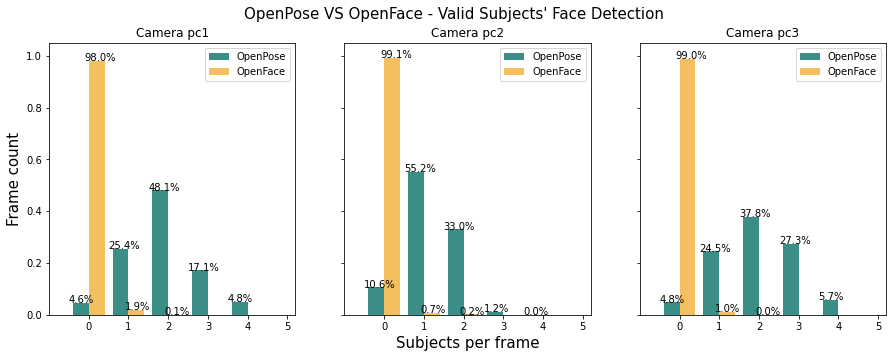

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(15,5))
fig.suptitle('OpenPose VS OpenFace - Valid Subjects\' Face Detection', size=15)
axes[1].set_xlabel('Subjects per frame', size=15)
axes[0].set_ylabel('Frame count', size=15)

TOTAL_FRAMES = len(openpose_face)/3

def normalize(vector: list, _min=0, _max=TOTAL_FRAMES):
    return (vector-_min) / (_max-_min)

for idx, ax in enumerate(axes):
    idx += 1
    ax.set_title('Camera pc'+str(idx))
    openpose_data = openpose_face[openpose_face['camera']=='pc'+str(idx)]['n_valids'].value_counts()
    openpose_bars = ax.bar(x=openpose_data.index-0.2, height=normalize(openpose_data.values), width=0.4, color='#3a8e86', label='OpenPose')
    openface_data = openface_face[openface_face['camera']=='pc'+str(idx)]['n_valids'].value_counts()
    openface_data_len = len(openface_face[openface_face['camera']=='pc'+str(idx)])
    openface_missing = TOTAL_FRAMES - openface_data_len
    if openface_missing != 0:
        openface_data = openface_data.append(pd.Series([openface_missing], index=[0]))
    openface_bars = ax.bar(x=openface_data.index+0.2, height=normalize(openface_data.values), width=0.4, color='#f4c05f', label='OpenFace')
    ax.set_xlim([-1, 5.2])
    ax.set_xticks(np.arange(6))
    ax.set_ylim([0, 1.05])
    ax.legend()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height*100
        ax.annotate('%.1f%%' % percentage, (x-0.1, y + height))
plt.show()

# Pose

## OpenPose

In [10]:
%%time
openpose_pose = df_structure.copy()

for GROUP_ID in GROUPS:
    if not Path(GROUP_ID+'_pose_openpose_df.csv').is_file():
        group_path = OPENPOSE_OUTPUT_DIR / GROUP_ID / (GROUP_ID + '_clean')
        tasks_paths = [x for x in group_path.iterdir() if 'task' in x.name]
        for task_path in tasks_paths:
            cameras_paths = [x for x in task_path.iterdir() if 'pc' in x.name]
            for camera_path in cameras_paths:                
                input_files = [x for x in camera_path.iterdir() if x.suffix in VALID_OUTPUT_FILE_TYPES]
                total_files = len(input_files)
                for file in input_files[:]:
                    frame = int(re.search(r'(?<=_)(\d{12})(?=_)',
                                              file.name).group(0))
                    data = json.load(open(file))
                    df = pd.json_normalize(data['subjects'], max_level=0)
                    n_subjects = len(df)
                    openpose_pose = openpose_pose.append({'group': GROUP_ID,
                                                          'task': task_path.name,
                                                          'camera': camera_path.name,
                                                          'frame': frame,
                                                          'n_subjects': n_subjects,
                                                          'n_valids': n_subjects}, # Same, as clean processed 
                                                                                   # filters invalid out.
                                                          ignore_index=True)
        openpose_pose.to_csv(GROUP_ID+'_pose_openpose_df.csv')
    else:
        print("File exists")
        tmp_openpose_pose = pd.read_csv(GROUP_ID+'_pose_openpose_df.csv', usecols=list(openpose_pose.columns))
        openpose_pose = openpose_pose.append(tmp_openpose_pose)

File exists
CPU times: user 97.7 ms, sys: 40.5 ms, total: 138 ms
Wall time: 137 ms


In [11]:
openpose_pose.head()

,group,task,camera,frame,n_subjects,n_valids
0,3CLC9VWR,task_1,pc2,23971,4,4
1,3CLC9VWR,task_1,pc2,14332,4,4
2,3CLC9VWR,task_1,pc2,24398,4,4
3,3CLC9VWR,task_1,pc2,4919,4,4
4,3CLC9VWR,task_1,pc2,7184,4,4


## DensePose

In [12]:
%%time
densepose_pose = df_structure.copy()

for GROUP_ID in GROUPS:
    if not Path(GROUP_ID+'_pose_densepose_df.csv').is_file():
        group_path = DENSEPOSE_OUTPUT_DIR / GROUP_ID / (GROUP_ID + '_clean')
        tasks_paths = [x for x in group_path.iterdir() if 'task' in x.name]
        for task_path in tasks_paths:
            cameras_paths = [x for x in task_path.iterdir() if 'pc' in x.name]
            for camera_path in cameras_paths:                
                input_files = [x for x in camera_path.iterdir() if x.suffix in VALID_OUTPUT_FILE_TYPES]
                total_files = len(input_files)
                for file in input_files[:]:
                    frame = int(re.search(r'(?<=_)(\d{12})(?=_)',
                                              file.name).group(0))
                    data = json.load(open(file))
                    df = pd.json_normalize(data['subjects'], max_level=0)
                    n_subjects = len(df)
                    densepose_pose = densepose_pose.append({'group': GROUP_ID,
                                                          'task': task_path.name,
                                                          'camera': camera_path.name,
                                                          'frame': frame,
                                                          'n_subjects': n_subjects,
                                                          'n_valids': n_subjects}, # Same, as clean processed 
                                                                                   # filters invalid out.
                                                          ignore_index=True)
        densepose_pose.to_csv(GROUP_ID+'_pose_densepose_df.csv')
    else:
        print("File exists")
        tmp_densepose_pose = pd.read_csv(GROUP_ID+'_pose_densepose_df.csv', usecols=list(densepose_pose.columns))
        densepose_pose = densepose_pose.append(tmp_densepose_pose)

File exists
CPU times: user 104 ms, sys: 32.1 ms, total: 136 ms
Wall time: 134 ms


In [13]:
densepose_pose.head()

,group,task,camera,frame,n_subjects,n_valids
0,3CLC9VWR,task_1,pc2,23971,4,4
1,3CLC9VWR,task_1,pc2,14332,4,4
2,3CLC9VWR,task_1,pc2,24398,4,4
3,3CLC9VWR,task_1,pc2,4919,3,3
4,3CLC9VWR,task_1,pc2,7184,4,4


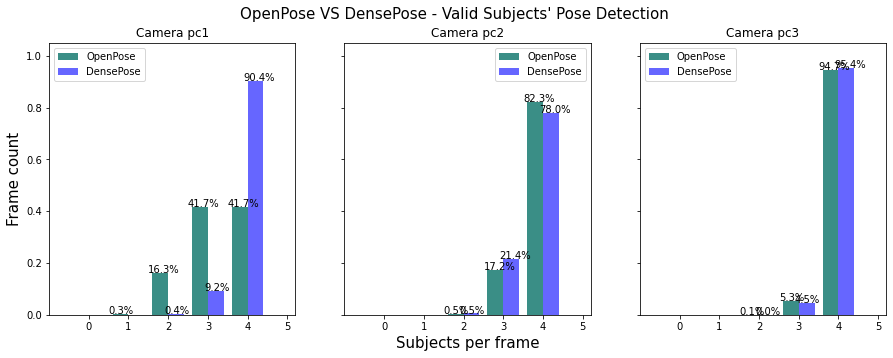

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(15,5))
fig.suptitle('OpenPose VS DensePose - Valid Subjects\' Pose Detection', size=15)
axes[1].set_xlabel('Subjects per frame', size=15)
axes[0].set_ylabel('Frame count', size=15)

for idx, ax in enumerate(axes):
    idx += 1
    ax.set_title('Camera pc'+str(idx))
    openpose_data = openpose_pose[openpose_pose['camera']=='pc'+str(idx)]['n_valids'].value_counts()
    openpose_bars = ax.bar(x=openpose_data.index-0.2, height=normalize(openpose_data.values), width=0.4, color='#3a8e86', label='OpenPose')
    densepose_data = densepose_pose[densepose_pose['camera']=='pc'+str(idx)]['n_valids'].value_counts()
    densepose_bars = ax.bar(x=densepose_data.index+0.2, height=normalize(densepose_data.values), width=0.4, color='#6666ff', label='DensePose')
    ax.set_xlim([-1, 5.2])
    ax.set_xticks(np.arange(6))
    ax.set_ylim([0, 1.05])
    ax.legend()
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        percentage = height*100
        ax.annotate('%.1f%%' % percentage, (x-0.1, y + height))
plt.show()